In [7]:
import sys
from rlnoise.dataset import Dataset, CircuitRepresentation
from rlnoise.policy import CNNFeaturesExtractor
import numpy as np
from rlnoise.envs.gym_env import QuantumCircuit
from stable_baselines3 import PPO, DQN, DDPG
from qibo.noise import DepolarizingError, NoiseModel
from qibo import gates, models


Create and save dataset (1st use)

In [10]:
nqubits = 1
depth = 10
ncirc = 4
noise_model = NoiseModel()
lam = 0.3
noise_model.add(DepolarizingError(lam), gates.RZ)
noise_channel = gates.DepolarizingChannel((0,), lam=lam)
primitive_gates = ['RZ', 'RX']
channels = ['DepolarizingChannel']

rep = CircuitRepresentation(
    primitive_gates = primitive_gates,
    noise_channels = channels,
    shape = '2d'
)
# create dataset
print("Creating Dataset of noisy/noiseless random circuit and their rapresentation")
dataset = Dataset(
    n_circuits = ncirc,
    n_gates = depth,
    n_qubits = nqubits,
    representation = rep,
    clifford = True,
    noise_model = noise_model,
    mode = 'rep'
)
#Testing the rapresentation of noisless and noisy circuits

circuit_rep = dataset[1] 
dataset.set_mode('circ')
circuit = dataset[1]
dataset.set_mode('noisy_circ')
noisy_circuit = dataset[1]

def test_representation():
    print('> Noiseless Circuit:\n', circuit.draw())
    array = rep.circuit_to_array(circuit)
    print(' --> Representation:\n', array)
    print(' --> Circuit Rebuilt:\n', rep.array_to_circuit(array).draw())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('> Noisy Circuit:\n', noisy_circuit.draw())
    array = rep.circuit_to_array(noisy_circuit)
    print(array)
    print(' --> Circuit Rebuilt:\n', rep.array_to_circuit(array).draw())

test_representation()
print('The shape of the representation is: ',rep.circuit_to_array(noisy_circuit).shape)
noisy_circuit=rep.circuit_to_array(noisy_circuit)
print('The dm_label of the circuit is: ',type(rep.array_to_circuit(noisy_circuit)))

''' 

In this representation we have shape (depth, x) where x is thge sum of:

num_of_possible_gates -> for each type of gate we have a column where if 1 that gate is present
(first column is RZ than RX ...)
1 -> this column represent the gate params
1 -> this column express if there is (1) or not (0) a noisy gate
1 -> this column represent the noisy gate params


'''
dm=np.asarray(circuit().state())
print(dm)

Creating Dataset of noisy/noiseless random circuit and their rapresentation
> Noiseless Circuit:
 q0: ─RX─RZ─RX─RX─RZ─RX─RZ─RZ─RX─RZ─
 --> Representation:
 [[0.   1.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.  ]
 [0.   1.   0.5  0.   0.  ]
 [0.   1.   0.5  0.   0.  ]
 [1.   0.   0.5  0.   0.  ]
 [0.   1.   0.75 0.   0.  ]
 [1.   0.   0.5  0.   0.  ]
 [1.   0.   1.   0.   0.  ]
 [0.   1.   1.   0.   0.  ]
 [1.   0.   0.5  0.   0.  ]]
 --> Circuit Rebuilt:
 q0: ─RX─RZ─RX─RX─RZ─RX─RZ─RZ─RX─RZ─
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
> Noisy Circuit:
 q0: ─RX─RZ─D─RX─RX─RZ─D─RX─RZ─D─RZ─D─RX─RZ─D─
[[0.   1.   0.   0.   0.  ]
 [1.   0.   0.   1.   0.3 ]
 [0.   1.   0.5  0.   0.  ]
 [0.   1.   0.5  0.   0.  ]
 [1.   0.   0.5  1.   0.3 ]
 [0.   1.   0.75 0.   0.  ]
 [1.   0.   0.5  1.   0.3 ]
 [1.   0.   1.   1.   0.3 ]
 [0.   1.   1.   0.   0.  ]
 [1.   0.   0.5  1.   0.3 ]]
 --> Circuit Rebuilt:
 q0: ─RX─RZ─D─RX─RX─RZ─D─RX─RZ─D─RZ─D─RX─RZ─D─
The shape of t

In [28]:


action=np.array([[1]]) #L'azione ha la dimensione (num_qubits, 1)
print(action.shape)
for q, a in enumerate(action): #a e` l'azione: se a=1 aggiungo rumore
    print('q= ',q)
    print('a= ',a)


(1, 1)
q=  0
a=  [1]


Load existing dataset

In [3]:
circuits_repr = np.load(dataset_folder() + '/dataset_1q.npy')
labels = np.load(dataset_folder() + '/labels_1q.npy')

print("Dataset loaded")
print("Number of circuits: ", len(circuits_repr))

Dataset loaded
Number of circuits:  100


Visualize circuit representation and observables distributions moments or density matrices

In [3]:
element=0

print("Circuit representation:")
print(circuits_repr[element])
print("Observables distribution moments or density matrices:")
print(labels[element])

Circuit representation:
[[0.         0.71079226]
 [1.         0.79643442]
 [0.         0.86050228]
 [1.         0.85349198]
 [0.         0.15389079]]
Observables distribution moments or density matrices:
[[ 0.37298306+2.77555756e-17j -0.03073506-3.83336736e-01j]
 [-0.03073506+3.83336736e-01j  0.62701694+0.00000000e+00j]]


Create RL environment

In [4]:
from rlnoise.envs.gym_env import CircuitsGym
from rlnoise.utils import truncated_moments_matching

env=CircuitsGym(circuits_repr, labels, reward_func=truncated_moments_matching, reward_method='dm', reward_each_step=True)
#env.set_reward_func(truncated_moments_matching)

Define ANN

In [5]:
import tensorflow as tf
from tensorflow import keras

num_inputs = env.observation_space.shape
num_actions = env.action_space.n

# CNN model
inputs = keras.layers.Input(shape=num_inputs)
common = keras.layers.Conv1D(8, (1,), activation="relu")(inputs)
common = keras.layers.Conv1D(4, (3,), padding='same', activation="relu")(common)
common = keras.layers.Flatten()(common)
action = keras.layers.Dense(num_actions, activation="softmax", name='Actor')(common)
critic = keras.layers.Dense(1, name='Critic')(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 8)         40          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 5, 4)         100         ['conv1d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 20)           0           ['conv1d_1[0][0]']               
                                                                                              

Define Agent

In [8]:
#from rlnoise.agents.actor_critic import AC_agent
from rlnoise.agents.actor_critic_V2 import AC_agent

agent=AC_agent(model, env)
agent.train_val_split(split=0.1)
agent.validation_options(do_validation=True, val_steps=100, greedy_policy=True)

Train set elements:  450
Validation set elements:  50


Train Agent

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
episodes=1000

train_history, val_history = agent.train(episodes=episodes, optimizer=optimizer, verbose_episode=100)

episode: 100, avg_reward 0.116611
Validation...
episode: 100, val_reward 0.040000
episode: 200, avg_reward 0.194518
Validation...
episode: 200, val_reward 0.040000
episode: 300, avg_reward 0.183280
Validation...
episode: 300, val_reward 0.040000
episode: 400, avg_reward 0.094558
Validation...
episode: 400, val_reward 0.040000
episode: 500, avg_reward 0.177004
Validation...
episode: 500, val_reward 0.040000
episode: 600, avg_reward 0.000000
Validation...
episode: 600, val_reward 0.040000
episode: 700, avg_reward 0.178232
Validation...
episode: 700, val_reward 0.040000
episode: 800, avg_reward 0.275156
Validation...
episode: 800, val_reward 0.040000
episode: 900, avg_reward 0.000000
Validation...
episode: 900, val_reward 0.040000
episode: 1000, avg_reward 0.085044
Validation...
episode: 1000, val_reward 0.040000


Save model

In [8]:
agent.save_model(filename="model_1q")

INFO:tensorflow:Assets written to: /home/simonebordoni/QIBO/rl-noisemodel/models/model_1q/assets


Visualize training history

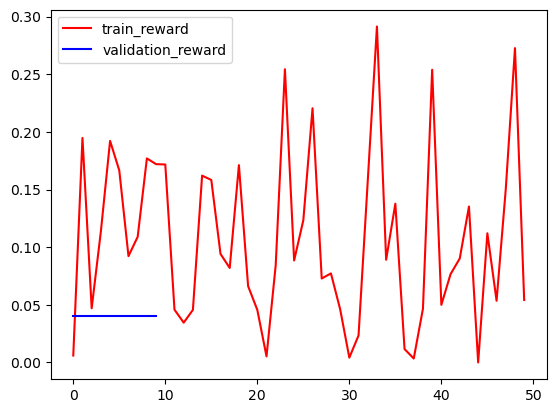

<Figure size 640x480 with 0 Axes>

In [10]:
from rlnoise.utils import plot_results
plot_results(train_history=train_history, val_history=val_history, n_steps=20)

In [ ]:
print(train_history[94])

{'circuit': 60, 'reward': 0.05579700667984001, 'final_state': array([[0.        , 0.08317755, 0.        , 0.        ],
       [1.        , 0.7326649 , 1.        , 0.        ],
       [1.        , 0.2620227 , 1.        , 0.        ],
       [1.        , 0.10362229, 1.        , 0.        ],
       [0.        , 0.7618408 , 0.        , 1.        ]], dtype=float32)}
